> 关于降维，需要注意的是：
> * 降维的主要目的是加快训练速度，而不是去除噪声和不必要的细节。
> * 降维肯定会损失一些信息，可能会让模型性能稍微变差。因此应该先在原维度训练，如果训练速度太慢再选择降维。
> * 降维除了能训练速度以外，还能用于数据可视化。把高维数据降到2维或3维，然后就能把特征在2维空间（3维空间）表示出来，能直观地发现一些规则。

# 主要降维方法
* 降维的方法主要为两种：投影(Projection) 和 流形学习(Manifold Learning)

## 投影(projection)
* 投影即将训练样本从高维投射到低维中。
* 不过投影不总是降维最好的方法在，比如许多情况下，空间可以扭转，如著名的瑞士卷（Swissroll）数据。如果简单的使用投影降维，就会把不同类别的样例都混在了一起。

## 流形学习(manifold learning)
* 流形数据是指d维数据在n维空间里弯曲。
* 基于流行数据进行建模的降维算法称为流形学习（Manifold Learning）。它假设大多数现实世界的高维数据集接近于一个低维流形。
* 流行学习隐含着另一个假设：通过流形在低维空间中表达，任务（例如分类或回归）应该变得简单。事实上这个假设并不能总是成立，降维后的模型效果可能有增有减。
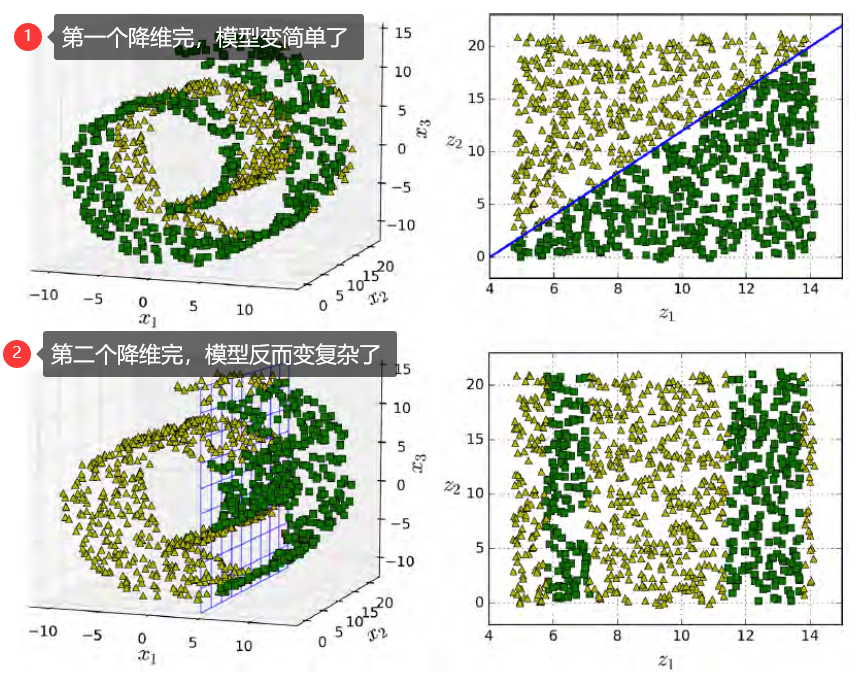

#  流行降维算法

## 主成分分析(PCA)
* 主成分分析（PCA）是最流行的降维技术，它通过确定最接近数据的超平面(hyperplane)，然后将数据投射(project)到该超平面上。
* 评价标准：保留方差(explained_variance)、均方误差(MSE)

### 主成分(Principal Components)：
* 算法首先找到第一个主成分向量，使得数据投影后保留方差最大。然后再找第二个主成分（要和第一个主成分正交）使得投影后保留方差最大，一直找到第t个主成分（要和1,2,…,t-1个主成分都正交）使得再投影后保留方差最大（t为目标降维数）。
* 可以通过奇异值分解（SVD）来把X矩阵分解为三个矩阵$U * {\sum} *V$，其中$V^T$矩阵的每个列向量就是主成分向量。

In [1]:
# 我们来求一下主成分

#产生数据
import numpy as np
x1=np.random.normal(0,1,100)
x2=x1*1+np.random.rand(100)
X=np.c_[x1,x2]

#svd分解求出主成分
X_centered = X - X.mean(axis=0) #特征缩放（PCA中必须！）
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
c1,c2

(array([0.69766922, 0.71642003]), array([-0.71642003,  0.69766922]))

### 投影到d维空间：
* 得到主成分以后就能将数据降维，假设降到d维空间，则用数据矩阵与前d个主成分形成的矩阵相乘，得到降维后的矩阵。
$$X_d = X * W_d\qquad W_d = V^T[:,:d]$$

In [3]:
# 投影到1d空间
d=1
Wd = V.T[:, :d]
X_1d = X_centered.dot(Wd)

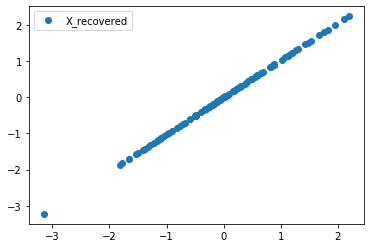

In [11]:
# 我们来重构2d数据
X_2d = np.dot(X_1d,Wd.T)

import matplotlib.pyplot as plt
plt.plot(X_2d[:,0],X_2d[:,1],'o',label="X_recovered")
plt.legend()
plt.show()

* 可以看出来，所有的点都被投射到1维直线上了。

* Scikit-learn提供了PCA类，n_components控制维数。
* components_可以输出主成分，explained_variance_ratio_可以查看保留方差的比率。

In [13]:
# 我们用sklearn提供的函数
from sklearn.decomposition import PCA
pca = PCA(n_components = 1) 
XD = pca.fit_transform(X)

#查看主成分
print(pca.components_.T)
print("-"*20)
#显示PCA主成分比率
print("主成分方差比率为：")
print(pca.explained_variance_ratio_)

[[-0.69766922]
 [-0.71642003]]
--------------------
主成分方差比率为：
[0.97876573]


### 选择合适的维数
* 合理的选择维数而不是随机选择一个维数，我们可以通过设置一个合适的方差比率（如95%），计算需要多少个主成分的方差比率和能达到这个比率，就选择该维度。

In [17]:
# 得到合适的维数d
pca = PCA()#没有设置n_components，默认为None
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_) #累加
d = np.argmax(cumsum >= 0.95) + 1 # 索引从0开始，需要加1

# 得到合适维度后再设置n_components
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X)

# 或者直接设置方差比率更简便
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

## 增量PCA(IPCA)
* 当数据量较大时，使用SVD分解会耗费很大的内存以及运算速度较慢。幸运的是，可以使用IPCA算法来解决。
* IPCA先将训练样本分为mini-batches，每次给IPCA算法一个mini-batch，这样就能处理大量的数据，也能实现在线学习（当有新的数据加入时）。

In [23]:
#加载数据
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('mnist-original',data_home='datasets')
X = mnist["data"]

#使用np.array_split（）方法的IPCA
from sklearn.decomposition import IncrementalPCA #导入IPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X, n_batches):
    inc_pca.partial_fit(X_batch) # 部分输入用partial_fit()

# 得到最终降维X
X_mnist_reduced = inc_pca.transform(X)

## 随机PCA
* 随机PCA是个随机算法，能快速找到接近前d个主成分，计算复杂度低，计算速度快。
* 随机PCA在Sklearn中需设置svd_solver = "randomized"。

In [25]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X)

## 核PCA(kernel PCA)
* 通过数学方法达到增加特征类似的功能来实现非线性投影降维，和SVM的核技巧类似。
* 该算法善于保持聚类后的集群(clusters)后投影，有时展开数据接近于扭曲的流形。

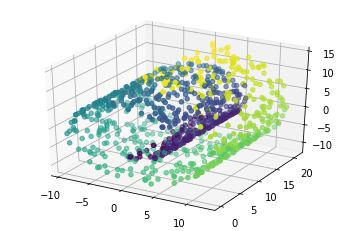

In [26]:
# 来看一下RBF核的例子

#生成Swiss roll数据
from sklearn.datasets import make_swiss_roll
data=make_swiss_roll(n_samples=1000, noise=0.0, random_state=None)
X=data[0]
y=data[1]

#画3维图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],c=y)
plt.show()

#kPCA
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### 选择合适的核和参数
* 由于kPCA是非监督算法，因此无法判断性能的好坏，因此需要结合分类或回归问题来判断。
* 我们可以通过GridSearch来选择合适的核与参数。

In [32]:
X.shape,y.shape

((70000, 784), (70000, 1))

In [46]:
# 载入数据
from sklearn.datasets import make_swiss_roll
data=make_swiss_roll(n_samples=1000, noise=0.0, random_state=None)
X=data[0]
y=data[1]

#导入相关的库
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 创建pipeline和网格搜索
clf = Pipeline([("kpca", KernelPCA(n_components=2)),
                ("log_reg", LogisticRegression())
])
param_grid = [{"kpca__gamma": np.linspace(0.03, 0.05, 10),
               "kpca__kernel": ["rbf", "sigmoid"]}]

# 找到最优模型
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X,y.astype("int"))
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'sigmoid'}


## 局部线性嵌入(LLE)
* 局部线性嵌入（Locally Linear Embedding）是另一种非线性降维技术。它基于流行学习而不是投影。
* LLE首先测量每个训练样例到其最近的邻居（CN）的线性关系，然后寻找一个低维表示使得这种相关性保持得最好。这使得它特别擅长展开扭曲的流形，特别是没有太多噪音的情况。

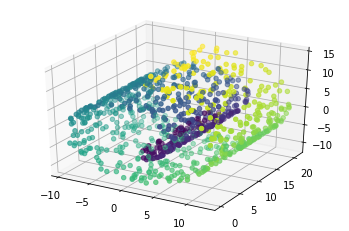

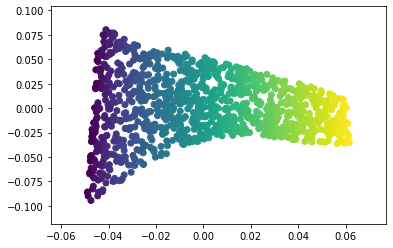

In [58]:
#生成Swiss roll数据
from sklearn.datasets import make_swiss_roll
data=make_swiss_roll(n_samples=1000, noise=0.0, random_state=None)
X=data[0]
y=data[1]

#画3维图
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2],c=y)
plt.show()

#LLe降维
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)

#画出降维图
X_reduced = lle.fit_transform(X)
plt.scatter(X_reduced[:,0],X_reduced[:,1],c=y)

# 其他降维技术
* 还有非常多降维的技术，例如：Multidimensional Scaling (MDS)、Isomap、t-Distributed Stochastic Neighbor Embedding (t-SNE)、Linear Discriminant Analysis (LDA)。

* Multidimensional Scaling (MDS)降维的同时保留样本之间的距离

* Isomap通过连接每个样本和它的最近邻居来创建一个图，然后降低维的同时尝试保留样本间的测地距离(两个样本之间最少经过几个点)。

* t-Distributed Stochastic Neighbor Embedding (t-SNE)，减少维度的同时试图保持相似的样本靠近和不同的样本分离。它主要用于可视化，特别是可视化高维空间中的聚类。

* Linear Discriminant Analysis (LDA)，是一种分类算法，但是在训练定义了一个超平面来投影数据。投影使得同一类的样本靠近，不同一类的样本分开，所以在运行另一分类算法（如SVM分类器）之前，LDA是一种很好的减少维数的技术。